In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

In [11]:

# read xml file
import xml.etree.ElementTree as ET
tree = ET.parse('project_12345_vorkalibriert_fxy123_cameras.xml')
root = tree.getroot()

# get all camera parameters
print(root.tag)
sensors = root.findall(".//sensor")
print(sensors)

liste = []
for sensor in sensors:
    sensor_parameters = sensor.findall("calibration")
    for sensor_parameter in sensor_parameters:
        if (sensor_parameter.attrib["class"] == "adjusted"):
            liste.append({
                "Fokus [dpt]": int(sensor.attrib["label"][-1]),
                "$c$": float(sensor_parameter.find("f").text),
                "$x'_0$": float(sensor_parameter.find("cx").text),
                "$y'_0$": float(sensor_parameter.find("cy").text),
                "$k_1$": float(sensor_parameter.find("k1").text),
                "$k_2$": float(sensor_parameter.find("k2").text),
                "$k_3$": float(sensor_parameter.find("k3").text),
            })

ist = pd.DataFrame(liste)
ist

document
[<Element 'sensor' at 0x7ca9606449f0>, <Element 'sensor' at 0x7ca9606457b0>, <Element 'sensor' at 0x7ca960646160>, <Element 'sensor' at 0x7ca960646b10>, <Element 'sensor' at 0x7ca9606474c0>, <Element 'sensor' at 0x7ca960647e70>, <Element 'sensor' at 0x7ca960648860>, <Element 'sensor' at 0x7ca960649210>, <Element 'sensor' at 0x7ca960649bc0>, <Element 'sensor' at 0x7ca96064a570>, <Element 'sensor' at 0x7ca96064af20>, <Element 'sensor' at 0x7ca96064b8d0>, <Element 'sensor' at 0x7ca9606082c0>, <Element 'sensor' at 0x7ca960608c70>, <Element 'sensor' at 0x7ca960609620>, <Element 'sensor' at 0x7ca960609fd0>, <Element 'sensor' at 0x7ca96060a980>, <Element 'sensor' at 0x7ca96060b330>, <Element 'sensor' at 0x7ca96060bce0>, <Element 'sensor' at 0x7ca96061c6d0>, <Element 'sensor' at 0x7ca96061d080>, <Element 'sensor' at 0x7ca96061da30>, <Element 'sensor' at 0x7ca96061e3e0>, <Element 'sensor' at 0x7ca96061ed90>, <Element 'sensor' at 0x7ca96061f740>, <Element 'sensor' at 0x7ca96062c130>, <E

,Fokus [dpt],$c$,$x'_0$,$y'_0$,$k_1$,$k_2$,$k_3$
0,2,3474.855230,11.148526,-1.478225,0.011858,0.080612,-0.216182
1,5,3556.351554,15.087590,-14.050707,0.016303,-0.091789,0.080744
2,1,3443.535672,13.339424,2.707556,0.028587,0.045391,-0.166522
3,3,3500.101466,12.826432,-2.521725,0.005554,0.075621,-0.185724
4,4,3524.313199,14.997503,-9.027845,-0.013582,0.181839,-0.368560
...,...,...,...,...,...,...,...
113,4,3487.289389,2.139893,-2.454923,-0.015294,0.236466,-0.479861
114,4,3480.056114,8.918707,16.687034,-0.030354,0.334500,-0.612354
115,4,3509.356420,3.924732,6.948872,0.037462,-0.016870,-0.113974
116,4,3498.144705,33.447523,-1.507268,-0.001082,0.097940,-0.181276


[  26.28275259 3397.25310053]
[0.19852054 9.12425931]
[-1.2273521   2.48052624]
[-0.00162832  0.032177  ]
[-0.02130586  0.10467775]
[ 0.03049618 -0.2668622 ]


<module 'matplotlib.pyplot' from '/mnt/ssd_daten/Studium/MScGeodaesieGeoinformatik/4_Thesis/Experimente/.venv/lib/python3.12/site-packages/matplotlib/pyplot.py'>

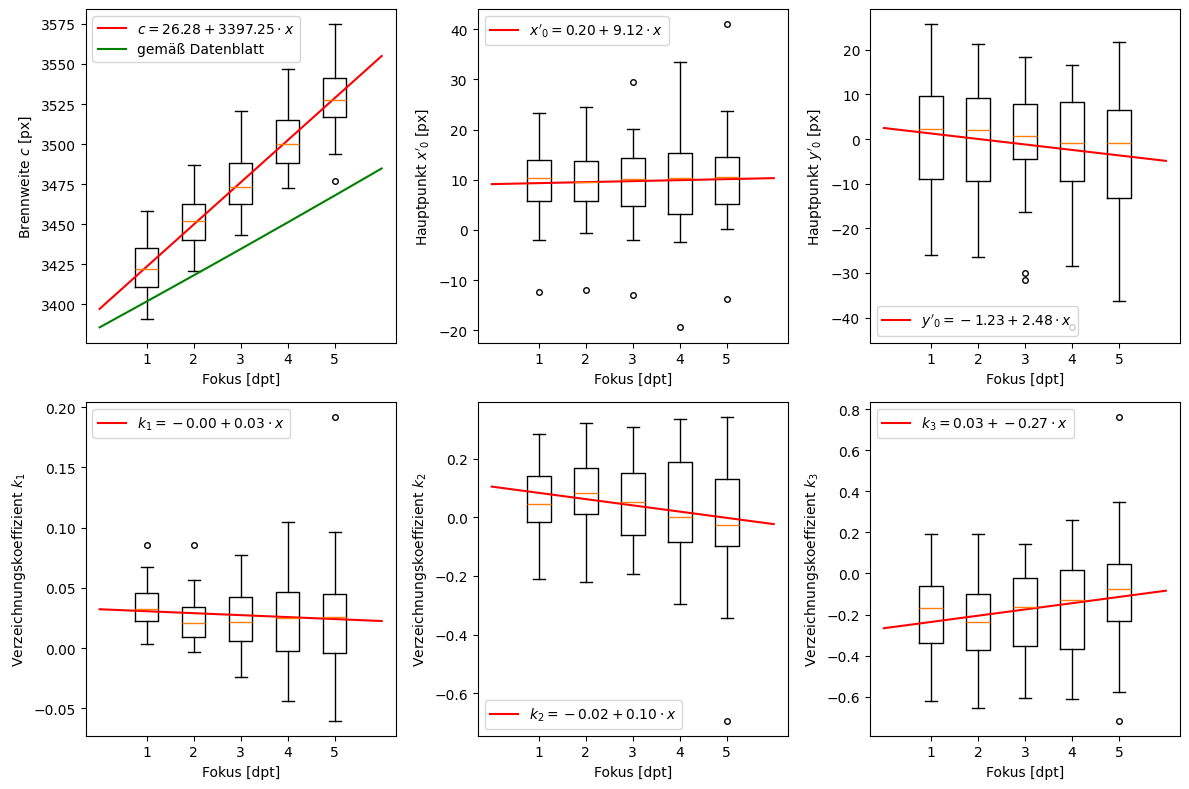

In [27]:
def gerade(x, a, b):
    return a * x + b


fig, axes = plt.subplots(2, 3, figsize=(12, 8))

beschriftung = {"$c$": "Brennweite $c$ [px]",
                "$x'_0$": "Hauptpunkt $x'_0$ [px]",
                "$y'_0$": "Hauptpunkt $y'_0$ [px]",
                "$k_1$": "Verzeichnungskoeffizient $k_1$",
                "$k_2$": "Verzeichnungskoeffizient $k_2$",
                "$k_3$": "Verzeichnungskoeffizient $k_3$"}

for i, col in enumerate(ist.columns.values[1:]):
    m = i // 3
    n = i % 3
    # ist.plot(x="Fokus [dpt]",
    #         y=[col], kind="scatter", ax=axes[m][n], sharex=True)
    k_group = ist.groupby("Fokus [dpt]")

    axes[m][n].boxplot(k_group[col].apply(
        list), positions=list(k_group.groups.keys()), flierprops=dict(marker='o', markersize=4))

    popt, pcov = curve_fit(gerade, ist['Fokus [dpt]'], ist[col])
    print(popt)
    x = np.array(list(range(0, 7)))
    y = gerade(x, *popt)
    axes[m][n].plot(x, y, color="red", label=col[:-1] + " = %4.2f + %4.2f \\cdot x$" %
                    (popt[0], popt[1]))

    if col == "$c$":
        def naehrung(x):
            return 1/(1/0.00474-x)/0.0000014
        x = np.array(list(range(0, 7)))
        y = naehrung(x)
        axes[m][n].plot(x, y, color="green", label="gemäß Datenblatt")

    axes[m][n].legend()
    axes[m][n].set_xlabel("Fokus [dpt]")
    axes[m][n].set_ylabel(beschriftung[col])


# Diagramm speichern
fig.tight_layout()
plt.savefig(
    "../../Thesis/img/naeherungswerte_diagramm.pdf", format="pdf")

plt

In [28]:
ist.cov()

,Fokus [dpt],$c$,$x'_0$,$y'_0$,$k_1$,$k_2$,$k_3$
Fokus [dpt],2.051282,53.913338,0.407222,-2.517645,-0.003340,-0.043704,0.062556
$c$,53.913338,1744.857207,-3.696841,-120.671673,-0.308983,-0.495950,0.950693
$x'_0$,0.407222,-3.696841,77.573326,-27.706448,0.001384,0.006850,0.009811
$y'_0$,-2.517645,-120.671673,-27.706448,187.430186,0.014511,0.053552,-0.171936
$k_1$,-0.003340,-0.308983,0.001384,0.014511,0.001135,-0.005250,0.007189
$k_2$,-0.043704,-0.495950,0.006850,0.053552,-0.005250,0.028356,-0.040844
$k_3$,0.062556,0.950693,0.009811,-0.171936,0.007189,-0.040844,0.060696


In [29]:
corr = ist.corr()
corr = corr.where(np.triu(np.ones(corr.shape)).astype(bool))
corr.to_latex("../../Thesis/tabs/naeherungswerte_corr.tex", float_format="%.3f",
              caption="Korrelationsmatrix der Näherungswerte", label="tab:naeherungswerte_corr", na_rep=" ", decimal=",")
corr

,Fokus [dpt],$c$,$x'_0$,$y'_0$,$k_1$,$k_2$,$k_3$
Fokus [dpt],1.0,0.901163,0.032282,-0.128399,-0.069218,-0.181212,0.177288
$c$,NaN,1.000000,-0.010048,-0.211011,-0.219544,-0.070507,0.092381
$x'_0$,NaN,NaN,1.000000,-0.229776,0.004665,0.004618,0.004521
$y'_0$,NaN,NaN,NaN,1.000000,0.031458,0.023229,-0.050976
$k_1$,NaN,NaN,NaN,NaN,1.000000,-0.925392,0.866105
$k_2$,NaN,NaN,NaN,NaN,NaN,1.000000,-0.984523
$k_3$,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
